In [1]:
import os
import sys
import argparse
import cv2
import math
import time
import numpy as np
import openpose.util as util
import keras.models
import digit_detector.region_proposal as rp
import digit_detector.show as show
import digit_detector.detect as detector
import digit_detector.file_io as file_io
import digit_detector.preprocess as preproc
import digit_detector.classify as cls
from openpose.config_reader import config_reader
from scipy.ndimage.filters import gaussian_filter
from model.cmu_model import get_testing_model

import matplotlib.pyplot as plt
%matplotlib inline


Using TensorFlow backend.


In [2]:
# find connection in the specified sequence, center 29 is in the position 15
limbSeq = [[2, 3], [2, 6], [3, 4], [4, 5], [6, 7], [7, 8], [2, 9], [9, 10], \
           [10, 11], [2, 12], [12, 13], [13, 14], [2, 1], [1, 15], [15, 17], \
           [1, 16], [16, 18], [3, 17], [6, 18]]

# the middle joints heatmap correpondence
mapIdx = [[31, 32], [39, 40], [33, 34], [35, 36], [41, 42], [43, 44], [19, 20], [21, 22], \
          [23, 24], [25, 26], [27, 28], [29, 30], [47, 48], [49, 50], [53, 54], [51, 52], \
          [55, 56], [37, 38], [45, 46]]

# visualize
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0],
          [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255],
          [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]

# digit-detection models and setting
detect_model = "model/digit-detector/detector_model.hdf5"
recognize_model = "model/digit-detector/recognize_model.hdf5"

mean_value_for_detector = 107.524
mean_value_for_recognizer = 112.833

model_input_shape = (32,32,1)

preproc_for_detector = preproc.GrayImgPreprocessor(mean_value_for_detector)
preproc_for_recognizer = preproc.GrayImgPreprocessor(mean_value_for_recognizer)

char_detector = cls.CnnClassifier(detect_model, preproc_for_detector, model_input_shape)
char_recognizer = cls.CnnClassifier(recognize_model, preproc_for_recognizer, model_input_shape)

digit_spotter = detector.DigitSpotter(char_detector, char_recognizer, rp.MserRegionProposer())

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\shing\Anaconda3\envs\game\lib\site-packages\keras\engine\base_layer.py:1109: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(name="convolution2d_1", activity_regularizer=None, trainable=True, input_dtype="float32", batch_input_shape=[None, 32,..., activation="linear", kernel_size=(3, 3), filters=32, strides=[1, 1], padding="valid", data_format="channels_last", kernel_initializer="glorot_uniform", kernel_regularizer=None, bias_regularizer=None, kernel_constraint=None, bias_constraint=None, use_bias=True)`
  return cls(**config)
C:\Users\shing\Anaconda3\envs\game\lib\site-packages\keras\engine\base_layer.py:1109: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(name="convolution2d_2", activity_regularizer=None, trainable=True, activation="linear", kernel_size=(3, 3), filters=32, strides=[1, 1], padding="valid", data_format="channels_last", kernel_initializer="glorot_uniform", kernel_regularizer=None, bias_regularizer=None, kernel_constraint=N

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\Users\shing\Anaconda3\envs\game\lib\site-packages\keras\engine\base_layer.py:1109: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(trainable=True, name="dropout_1", rate=0.5)`
  return cls(**config)
C:\Users\shing\Anaconda3\envs\game\lib\site-packages\keras\engine\base_layer.py:1109: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(name="dense_2", activity_regularizer=None, trainable=True, input_dim=1024, activation="linear", units=2, kernel_initializer="glorot_uniform", kernel_regularizer=None, bias_regularizer=None, kernel_constraint=None, bias_constraint=None, use_bias=True)`
  return cls(**config)


Instructions for updating:
Use tf.cast instead.


C:\Users\shing\Anaconda3\envs\game\lib\site-packages\keras\engine\base_layer.py:1109: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(name="convolution2d_1", activity_regularizer=None, trainable=True, input_dtype="float32", batch_input_shape=[None, 32,..., activation="linear", kernel_size=(3, 3), filters=64, strides=[1, 1], padding="valid", data_format="channels_last", kernel_initializer="glorot_uniform", kernel_regularizer=None, bias_regularizer=None, kernel_constraint=None, bias_constraint=None, use_bias=True)`
  return cls(**config)
C:\Users\shing\Anaconda3\envs\game\lib\site-packages\keras\engine\base_layer.py:1109: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(name="convolution2d_2", activity_regularizer=None, trainable=True, activation="linear", kernel_size=(3, 3), filters=64, strides=[1, 1], padding="valid", data_format="channels_last", kernel_initializer="glorot_uniform", kernel_regularizer=None, bias_regularizer=None, kernel_constraint=N

In [3]:
input_image = 'C:/Users/shing/Desktop/2.jpg'

model = get_testing_model()
model.load_weights('model/keras/model.h5')

params, model_params = config_reader()

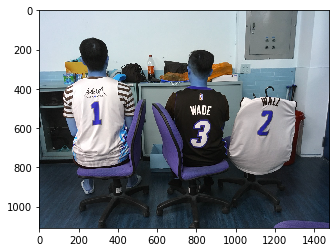

In [4]:
oriImg = cv2.imread(input_image)
plt.imshow(oriImg)

In [5]:
multiplier = [x * model_params['boxsize'] / oriImg.shape[0] for x in params['scale_search']]

heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 19))
paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 38))

for m in range(len(multiplier)):
    scale = multiplier[m]

    imageToTest = cv2.resize(oriImg, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    imageToTest_padded, pad = util.padRightDownCorner(imageToTest, model_params['stride'],
                                                      model_params['padValue'])

    input_img = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,0,1,2)) # required shape (1, width, height, channels)

    output_blobs = model.predict(input_img)

    # extract outputs, resize, and remove padding
    heatmap = np.squeeze(output_blobs[1])  # output 1 is heatmaps
    heatmap = cv2.resize(heatmap, (0, 0), fx=model_params['stride'], fy=model_params['stride'],
                         interpolation=cv2.INTER_CUBIC)
    heatmap = heatmap[:imageToTest_padded.shape[0] - pad[2], :imageToTest_padded.shape[1] - pad[3],
              :]
    heatmap = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

    paf = np.squeeze(output_blobs[0])  # output 0 is PAFs
    paf = cv2.resize(paf, (0, 0), fx=model_params['stride'], fy=model_params['stride'],
                     interpolation=cv2.INTER_CUBIC)
    paf = paf[:imageToTest_padded.shape[0] - pad[2], :imageToTest_padded.shape[1] - pad[3], :]
    paf = cv2.resize(paf, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

    heatmap_avg = heatmap_avg + heatmap / len(multiplier)
    paf_avg = paf_avg + paf / len(multiplier)

all_peaks = []
peak_counter = 0

for part in range(18):
    map_ori = heatmap_avg[:, :, part]
    map = gaussian_filter(map_ori, sigma=3)

    map_left = np.zeros(map.shape)
    map_left[1:, :] = map[:-1, :]
    map_right = np.zeros(map.shape)
    map_right[:-1, :] = map[1:, :]
    map_up = np.zeros(map.shape)
    map_up[:, 1:] = map[:, :-1]
    map_down = np.zeros(map.shape)
    map_down[:, :-1] = map[:, 1:]

    peaks_binary = np.logical_and.reduce(
        (map >= map_left, map >= map_right, map >= map_up, map >= map_down, map > params['thre1']))
    peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]))  # note reverse
    peaks_with_score = [x + (map_ori[x[1], x[0]],) for x in peaks]
    id = range(peak_counter, peak_counter + len(peaks))
    peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]

    all_peaks.append(peaks_with_score_and_id)
    peak_counter += len(peaks)

connection_all = []
special_k = []
mid_num = 10

for k in range(len(mapIdx)):
    score_mid = paf_avg[:, :, [x - 19 for x in mapIdx[k]]]
    candA = all_peaks[limbSeq[k][0] - 1]
    candB = all_peaks[limbSeq[k][1] - 1]
    nA = len(candA)
    nB = len(candB)
    indexA, indexB = limbSeq[k]
    if (nA != 0 and nB != 0):
        connection_candidate = []
        for i in range(nA):
            for j in range(nB):
                vec = np.subtract(candB[j][:2], candA[i][:2])
                norm = math.sqrt(vec[0] * vec[0] + vec[1] * vec[1])
                # failure case when 2 body parts overlaps
                if norm == 0:
                    continue
                vec = np.divide(vec, norm)

                startend = list(zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), \
                               np.linspace(candA[i][1], candB[j][1], num=mid_num)))

                vec_x = np.array(
                    [score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 0] \
                     for I in range(len(startend))])
                vec_y = np.array(
                    [score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 1] \
                     for I in range(len(startend))])

                score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                score_with_dist_prior = sum(score_midpts) / len(score_midpts) + min(
                    0.5 * oriImg.shape[0] / norm - 1, 0)
                criterion1 = len(np.nonzero(score_midpts > params['thre2'])[0]) > 0.8 * len(
                    score_midpts)
                criterion2 = score_with_dist_prior > 0
                if criterion1 and criterion2:
                    connection_candidate.append([i, j, score_with_dist_prior,
                                                 score_with_dist_prior + candA[i][2] + candB[j][2]])

        connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
        connection = np.zeros((0, 5))
        for c in range(len(connection_candidate)):
            i, j, s = connection_candidate[c][0:3]
            if (i not in connection[:, 3] and j not in connection[:, 4]):
                connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                if (len(connection) >= min(nA, nB)):
                    break

        connection_all.append(connection)
    else:
        special_k.append(k)
        connection_all.append([])

# last number in each row is the total parts number of that person
# the second last number in each row is the score of the overall configuration
subset = -1 * np.ones((0, 20))
candidate = np.array([item for sublist in all_peaks for item in sublist])

for k in range(len(mapIdx)):
    if k not in special_k:
        partAs = connection_all[k][:, 0]
        partBs = connection_all[k][:, 1]
        indexA, indexB = np.array(limbSeq[k]) - 1

        for i in range(len(connection_all[k])):  # = 1:size(temp,1)
            found = 0
            subset_idx = [-1, -1]
            for j in range(len(subset)):  # 1:size(subset,1):
                if subset[j][indexA] == partAs[i] or subset[j][indexB] == partBs[i]:
                    subset_idx[found] = j
                    found += 1

            if found == 1:
                j = subset_idx[0]
                if (subset[j][indexB] != partBs[i]):
                    subset[j][indexB] = partBs[i]
                    subset[j][-1] += 1
                    subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
            elif found == 2:  # if found 2 and disjoint, merge them
                j1, j2 = subset_idx
                membership = ((subset[j1] >= 0).astype(int) + (subset[j2] >= 0).astype(int))[:-2]
                if len(np.nonzero(membership == 2)[0]) == 0:  # merge
                    subset[j1][:-2] += (subset[j2][:-2] + 1)
                    subset[j1][-2:] += subset[j2][-2:]
                    subset[j1][-2] += connection_all[k][i][2]
                    subset = np.delete(subset, j2, 0)
                else:  # as like found == 1
                    subset[j1][indexB] = partBs[i]
                    subset[j1][-1] += 1
                    subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]

            # if find no partA in the subset, create a new subset
            elif not found and k < 17:
                row = -1 * np.ones(20)
                row[indexA] = partAs[i]
                row[indexB] = partBs[i]
                row[-1] = 2
                row[-2] = sum(candidate[connection_all[k][i, :2].astype(int), 2]) + \
                          connection_all[k][i][2]
                subset = np.vstack([subset, row])

# delete some rows of subset which has few parts occur
deleteIdx = [];
for i in range(len(subset)):
    if subset[i][-1] < 4 or subset[i][-2] / subset[i][-1] < 0.4:
        deleteIdx.append(i)
subset = np.delete(subset, deleteIdx, axis=0)

canvas = cv2.imread(input_image)  # B,G,R order
#for i in range(18):
    #for j in range(len(all_peaks[i])):
        #cv2.circle(canvas, all_peaks[i][j][0:2], 4, colors[i], thickness=-1)

stickwidth = 4

# 關節及肢體顯示
for n in range(len(subset)):
    #把每個人的髖關節角度算出來
    angles = []
    for ls1, ls2, ls3 in [(1, 8, 9), (1, 11, 12)]:
        X1 = candidate[int(subset[n][ls1]), 0]
        Y1 = candidate[int(subset[n][ls1]), 1]
        X2 = candidate[int(subset[n][ls2]), 0]
        Y2 = candidate[int(subset[n][ls2]), 1]
        X3 = candidate[int(subset[n][ls3]), 0]
        Y3 = candidate[int(subset[n][ls3]), 1]

        points = np.array([[X1, Y1], [X2, Y2], [X3, Y3]])

        A = points[1] - points[0]
        B = points[2] - points[1]
        C = points[0] - points[2]

        #for e1, e2 in ((A, -B), (B, -C), (C, -A)):
        num = np.dot(A, -B)
        denom = np.linalg.norm(A) * np.linalg.norm(-B)
        angles.append(np.arccos(num/denom) * 180 / np.pi)

    # 如果此人兩個髖關節有一個角度>110 則判斷此人站著
    if any (a > 110 for a in angles):
        #pass
    #else:
        all_X=[]
        all_Y=[]                 
        for i in range(17):
            index = subset[n][np.array(limbSeq[i])-1]
            if -1 in index:
                continue
            cur_canvas = canvas.copy()
            #該人身上所有關節點的X,Y座標
            X = candidate[index.astype(int), 0]
            Y = candidate[index.astype(int), 1]
            #該人身上的所有關節點的X,Y座標最大, 最小, 平均值
            #mX = np.mean(X)
            #mY = np.mean(Y)
            all_X.append(int(X[0]))
            all_X.append(int(X[1]))
            all_Y.append(int(Y[0]))
            all_Y.append(int(Y[1]))


            #length = ((Y[0] - Y[1]) ** 2 + (X[0] - X[1]) ** 2) ** 0.5
            #angle = math.degrees(math.atan2(Y[0] - Y[1], X[0] - X[1]))

            #polygon = cv2.ellipse2Poly((int(mX),int(mY)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
            # cv2.fillConvexPoly填充多邊形(給予凸點的位置即可)
            #cv2.fillConvexPoly(cur_canvas, polygon, colors[i])
            # cv2.addWeighted 兩張圖片疊加 (底圖, 底圖權重, 頂圖, 頂圖權重)
            #canvas = cv2.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)


        # 設定背號會出現的位置
        X4 = int(candidate[int(subset[n][2]), 0])
        Y4 = int(candidate[int(subset[n][2]), 1])
        X5 = int(candidate[int(subset[n][5]), 0])
        Y5 = int(candidate[int(subset[n][5]), 1])

        sq_Ymin=min(Y4, Y5)
        sq_Xmin=min(X4, X5)
        sq_Xmax=max(X4, X5)
        z=int((sq_Xmax-sq_Xmin)/3)
        body_ori = oriImg[(sq_Ymin+z):(sq_Ymin+4*z), (sq_Xmin-z):(sq_Xmax+z)]
        # 影像去噪
        body_img = np.array(cv2.fastNlMeansDenoisingColored(body_ori, None, 10, 10, 7, 21))
        result = digit_spotter.run(body_img, threshold=0.5, do_nms=True, show_result=True, nms_threshold=0.1)

        if result is not None:        
            min_X = np.min(all_X)
            max_X = np.max(all_X)
            min_Y = np.min(all_Y)
            max_Y = np.max(all_Y)
            mean_X = int((min_X+max_X)/2) 
            #objectId = str(n)

            # cv2.rectangle畫框 (圖, 左上角座標, 右下角座標, 顏色BGR, 粗细)
            cv2.rectangle(canvas, (min_X,max_Y), (max_X,min_Y), (0,255,0), 4)
            # cv2.putText 標示文字 (圖, 文字, 位置, 字體, 大小, 顏色BGR, 粗细)
            cv2.putText(canvas,str(result),(mean_X,(min_Y-10)),cv2.FONT_HERSHEY_COMPLEX,0.5,(0,255,0),1)
        else:
            pass
cv2.imshow("result", canvas)
cv2.waitKey(0)
cv2.destroyAllWindows()